# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Bagging and Pasting

Una forma de obtener un conjunto diverso de clasificadores es utilizar algoritmos de entrenamiento muy diferentes, como acabamos de ver. 

Otro método consiste en utilizar el mismo algoritmo de entrenamiento para cada predictor, pero entrenarlos en diferentes subconjuntos aleatorios del conjunto de entrenamiento. 

Cuando el muestreo se realiza con reemplazo (la misma observación puede aparecer en varios veces en el mismo modelo), este método se denomina bagging (abreviatura de bootstrap aggregating). 

Cuando el muestreo se realiza sin reemplazo (la misma observación sólo puede aparecer en una vez en cada modelo), se denomina pasting.


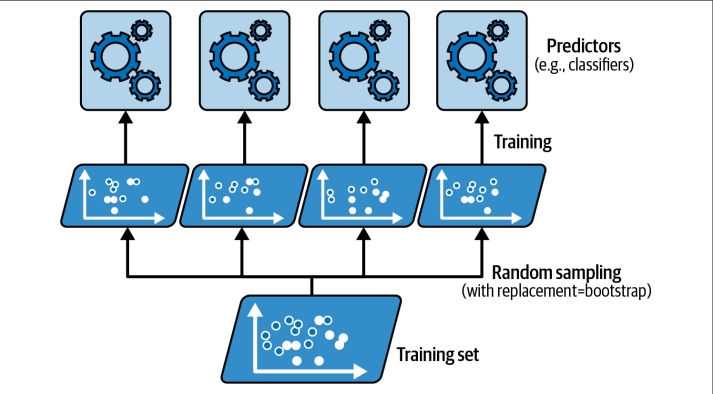

Una vez entrenados todos los predictores, el conjunto puede realizar una predicción para una nueva instancia simplemente agregando las predicciones de todos los predictores. 

La función de agregación suele ser el modo estadístico para la clasificación (es decir, la predicción más frecuente o moda, como en un clasificador de hard voting), o la media para la regresión. 

Cada predictor individual tiene un bias mayor que si se hubiera entrenado con el conjunto de entrenamiento original, pero la agregación reduce tanto el bias como la variance. 

Generalmente, el resultado neto es que el conjunto tiene un bias similar pero una variance menor que un único predictor entrenado con el conjunto de entrenamiento original.


![Sin título.jpg](<attachment:Sin título.jpg>)
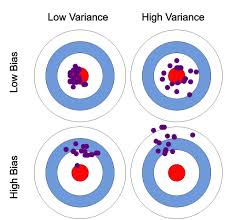

## Bagging and Pasting in Scikit-Learn

La clase BaggingClassifier (o BaggingRegressor para regresión) nos permite implementar bagging y pasting con sklearn.

El siguiente código entrena un conjunto de 500 clasificadores de árbol de decisión: cada uno se entrena en 100 instancias de entrenamiento muestreadas aleatoriamente del conjunto de entrenamiento con reemplazo (bootstrap=True) o sin reemplazo (bootstrap=False)

El parámetro n_jobs indica a Scikit-Learn el número de núcleos de CPU que debe utilizar para el entrenamiento y las predicciones, y -1 indica a Scikit-Learn que utilice todos los núcleos disponibles:

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

Un clasificador Bagging realiza automáticamente un soft voting en lugar de un hard voting si el clasificador base puede estimar las probabilidades de clase (es decir, si tiene un método predict_proba()), que es el caso de los clasificadores de árbol de decisión.


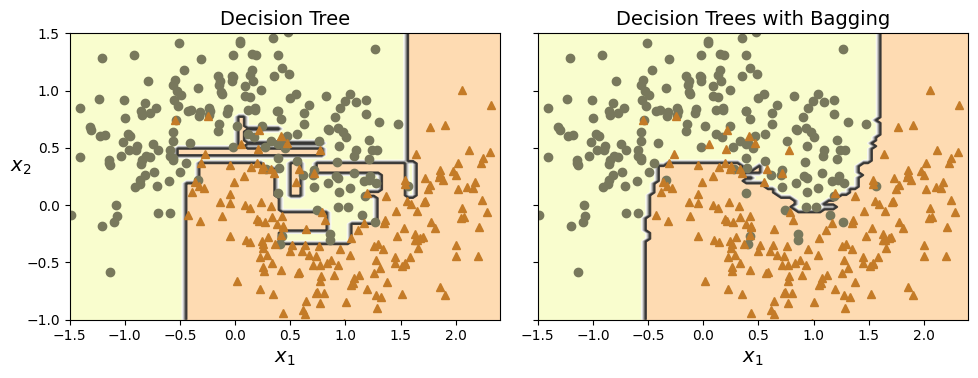

In [5]:
import numpy as np
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

La figura compara el límite de decisión de un único árbol de decisión con el límite de decisión de un conjunto de 500 árboles, ambos entrenados en el conjunto de datos de lunas. 

Como puede ver, las predicciones del conjunto probablemente se generalizarán mucho mejor que las predicciones del árbol de decisión único: el conjunto tiene un sesgo comparable pero una varianza menor (comete aproximadamente el mismo número de errores en el conjunto de entrenamiento, pero el límite de decisión es menos irregular).

El bagging introduce un poco más de diversidad en los subconjuntos en los que se entrena cada predictor, por lo que acaba teniendo un bias ligeramente mayor; pero la diversidad adicional también significa que los predictores acaban estando menos correlacionados, por lo que se reduce la variance del conjunto. 

En general, el bagging suele dar lugar a mejores modelos, lo que explica por qué suele preferirse. Con tiempo y CPU, se puede utilizar Cross Validation para evaluar tanto el bagging como el pasting y seleccionar el que mejor funcione.


In [6]:
# Vamos a comprobar que para cada uno de los 500 árboles hay reemplazamiento o no
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42, bootstrap=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [7]:
import pandas as pd
pd.DataFrame(bag_clf.estimators_samples_)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,41,332,130,231,92,199,370,120,28,233,...,146,36,303,279,340,240,352,39,120,292
1,174,151,279,31,357,234,3,303,202,83,...,191,329,60,327,99,313,354,228,328,183
2,342,288,71,231,250,168,188,373,18,53,...,202,52,141,361,74,86,22,330,87,90
3,288,69,55,63,202,4,369,211,374,299,...,136,62,309,159,151,1,9,288,280,284
4,237,350,70,25,230,235,35,143,8,99,...,8,303,257,150,186,143,79,19,353,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,224,11,280,39,0,22,73,313,160,291,...,292,32,347,189,190,246,335,97,296,119
496,6,241,148,188,207,174,120,51,352,188,...,61,108,6,140,139,25,86,312,90,238
497,348,178,130,45,301,374,53,315,355,62,...,339,315,270,27,343,20,359,368,264,335
498,178,371,169,251,21,63,118,294,152,101,...,22,336,291,351,36,284,347,211,131,140


In [8]:
# Repetir sin reemplazamiento
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42, bootstrap=False)
bag_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=False, estimator=DecisionTreeClassifier(),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=42)

In [9]:
import pandas as pd
pd.DataFrame(bag_clf.estimators_samples_).nunique(axis=1).value_counts()

100    500
Name: count, dtype: int64

In [10]:
# Repetir sin reemplazamiento
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42, bootstrap=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [11]:
import pandas as pd
pd.DataFrame(bag_clf.estimators_samples_).nunique(axis=1).value_counts(normalize=True)

88    0.150
89    0.120
87    0.112
90    0.110
91    0.098
86    0.098
85    0.064
92    0.056
84    0.054
93    0.038
82    0.024
83    0.020
81    0.016
94    0.016
80    0.012
95    0.004
79    0.004
96    0.004
Name: proportion, dtype: float64

In [12]:
pd.DataFrame(bag_clf.estimators_samples_).nunique(axis=1).value_counts(normalize=True).reset_index()

,index,proportion
0,88,0.150
1,89,0.120
2,87,0.112
3,90,0.110
4,91,0.098
5,86,0.098
6,85,0.064
7,92,0.056
8,84,0.054
9,93,0.038


## OOB
Evaluación out of bagging

Con bagging, algunas instancias/observaciones/muestras de entrenamiento pueden aparecer varias veces para cualquier predictor dado, mientras que existe la posibilidad de que otras no aprezcan en ninguno nunca.

Hemos comprobado que el resultado nos daba en torno al XX.X%. El subconjunto restante se denomina OOB: out of bagging



Un conjunto de bagging puede evaluarse utilizando instancias OOB, sin necesidad de un conjunto de validación separado: incluso, si hay suficientes estimadores, entonces cada instancia del conjunto de entrenamiento será probablemente una instancia OOB de varios estimadores, por lo que estos estimadores pueden utilizarse para realizar una predicción para esa instancia. 

Una vez que tenga una predicción para cada caso, puede calcular la precisión de la predicción del conjunto (o cualquier otra métrica).

En Scikit-Learn, puede establecer oob_score=True al crear un BaggingClassifier para solicitar una evaluación OOB automática después del entrenamiento.

In [13]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [14]:
len(X_train)

375

In [15]:
# Media no ponderada
pd.DataFrame(bag_clf.estimators_samples_).nunique(axis=1).value_counts().reset_index()["index"].mean()/375

0.6318383838383839

In [16]:
# Media ponderada
pd.DataFrame(bag_clf.estimators_samples_).nunique(axis=1).mean()/375

0.632176

Según esta evaluación OOB, es probable que este BaggingClassifier consiga una precisión del 89,6% en el conjunto de prueba. Verifiquemos esto:

In [17]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [18]:
y_pred = bag_clf.predict(X_train)
accuracy_score(y_train, y_pred)

1.0

In [19]:
bag_clf.oob_decision_function_[:3]  # probas para las 3 primeras instancias

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [20]:
bag_clf.predict_proba(X_test[:3])

array([[0.342, 0.658],
       [0.616, 0.384],
       [0.736, 0.264]])

In [21]:
bag_clf.estimators_

[DecisionTreeClassifier(random_state=1952926171),
 DecisionTreeClassifier(random_state=1761383086),
 DecisionTreeClassifier(random_state=1449071958),
 DecisionTreeClassifier(random_state=1910541088),
 DecisionTreeClassifier(random_state=1341730541),
 DecisionTreeClassifier(random_state=1286572245),
 DecisionTreeClassifier(random_state=1005142668),
 DecisionTreeClassifier(random_state=502852014),
 DecisionTreeClassifier(random_state=186414760),
 DecisionTreeClassifier(random_state=1956263048),
 DecisionTreeClassifier(random_state=15592051),
 DecisionTreeClassifier(random_state=1628376228),
 DecisionTreeClassifier(random_state=1638437331),
 DecisionTreeClassifier(random_state=116435712),
 DecisionTreeClassifier(random_state=588556688),
 DecisionTreeClassifier(random_state=358068376),
 DecisionTreeClassifier(random_state=67998415),
 DecisionTreeClassifier(random_state=825108120),
 DecisionTreeClassifier(random_state=1237545031),
 DecisionTreeClassifier(random_state=1708477288),
 DecisionT

In [22]:
bag_clf.estimators_samples_

[array([ 41, 332, 130, 231,  92, 199, 370, 120,  28, 233,  84,   6, 324,
        338, 307, 105,  74, 290, 349, 260, 290,   8, 288,  59,  95,   3,
        150, 363, 302, 116, 194, 361,  77, 184, 336, 242, 241, 213,  64,
        256,  59, 103, 337,  41, 347,  70, 132, 256,  60, 279,  14, 234,
        249, 183, 203, 301, 340, 165, 100, 173, 213, 367,  23,  70,   1,
        337, 172, 294, 353, 367, 371,  52,   9, 338, 327, 109,  73, 372,
        217, 196,  14, 288, 104, 299, 104,  45, 357,  53, 261, 370, 146,
         36, 303, 279, 340, 240, 352,  39, 120, 292,   0, 135, 254, 122,
        269, 222, 265,  15, 191, 262, 333,  48,  27,  70, 316, 173,  49,
        131, 268,  85, 184, 303,  99, 318,   1,  90, 244, 227, 166, 251,
         36,  86, 236,  64,  66, 211,  68, 332, 313,  87, 221,  93, 110,
         79,  65, 208, 313, 199,  75,   5, 198, 200, 358, 270,   1, 157,
         26,  97, 272, 239, 224, 322, 175, 251, 138, 245,  62, 121,  11,
        373,  24,  74, 292,  23, 103, 286, 292, 320

Obtenemos un 92% de precisión en la prueba. La evaluación OOB fue un poco pesimista, algo más de un 2% demasiado baja. 

La función de decisión OOB para cada instancia de entrenamiento también está disponible a través del atributo oob_decision_function_. 

Dado que el estimador base tiene un método predict_proba(), la función de decisión devuelve las probabilidades de clase para cada instancia de entrenamiento. 

Por ejemplo, la evaluación OOB estima que la primera instancia de entrenamiento tiene una probabilidad del 67,6% de pertenecer a la clase positiva y una probabilidad del 32,4% de pertenecer a la clase negativa:

# La matemáticas

Si se extrae aleatoriamente una instancia de un conjunto de datos de tamaño _m_, cada instancia del conjunto de datos tiene obviamente una probabilidad 1/_m_ de ser elegida y, por lo tanto, tiene una probabilidad 1 - 1/_m_ de _no_ ser elegida. 

Si se extraen _m_ instancias con reemplazo, todas las extracciones son independientes y, por tanto, cada instancia tiene una probabilidad (1 - 1/_m_)<sup>m_</sup> de _no_ ser escogida. Ahora utilicemos el hecho de que exp(_x_) es igual al límite de (1 + _x_/_m_)<sup>m_</sup> a medida que _m_ se acerca a infinito. 

Así que si _m_ es grande, la proporción de instancias fuera de la bolsa será aproximadamente exp(-1) ≈ 0,37. Así que aproximadamente el 63% (1 - 0,37) será muestreado.

In [23]:
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# Volviendo al ejercicio del impago

In [24]:
# https://www.kaggle.com/code/caesarlupum/modeling-give-me-some-credit
import pandas as pd
data = pd.read_csv("data/train.csv")

In [25]:
data["age"] = data["age"].str.replace("y", "").astype(int)
data.drop(columns=["Id"], inplace=True)
data = data.dropna()

In [26]:
X = data.drop(columns=["target"])
y = data["target"]

In [27]:
# Hacer una función con todo y probar diversos arboles StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1453)
for train_index, test_index in split.split(X, y):
    strat_train_set = X.iloc[train_index]
    strat_train_y_set = y.iloc[train_index]
    strat_test_set = X.iloc[test_index]
    strat_test_y_set = y.iloc[test_index]

In [28]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(strat_train_set, strat_train_y_set)


BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=42)

In [32]:
# Calcula accuracy  
accuracy_score(strat_test_y_set, bag_clf.predict(strat_test_set))


0.9310374149659864

In [34]:
from sklearn.metrics import recall_score
recall_score(strat_test_y_set, bag_clf.predict(strat_test_set))

0.17515527950310558

In [30]:
# Calcula oob_score

In [31]:
# Comprueba que se calculan bien las probabilidades

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'estimator__max_depth': range(2,13),
    'estimator__min_samples_leaf': range(1,31)
}

grid_search = GridSearchCV(BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500), # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   cv=5, # Folds del cross validation
                                   scoring="recall", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

grid_search.fit(strat_train_set, strat_train_y_set)